# Kaggle Mini-Project
by Julian Moscotte

Title:

# EDA

The first thing we're going to do is take a look at what each of our test and train data sets contain. Then we'll go over the different statistics of the data so we can make a decision on how we want to do our analysis. 

In [63]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from collections import Counter
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmosc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
test_data = pd.read_csv("data/BBC News Test.csv")
train_data = pd.read_csv("data/BBC News Train.csv")
solution_data = pd.read_csv("data/BBC News Train.csv")

In [65]:
display(train_data)
train_data.info()

duplicates = train_data.duplicated().sum()

print("Duplicate Values: " + str(duplicates))

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
Duplicate Values: 0


A first look at our training data shows that we have 1490 records with 3 columns:

- ArticleID (Int):  Article id unique # given to the record
- Text (Object):  text of the header and article
- Category (Object): cateogry of the article (tech, business, sport, entertainment, politics

As well as a data set with no null values and no duplicates, so we're working with a clean data set from here on out. 

In [66]:
display(test_data)

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


And our test data contains similar columns excluding the Category since this is the set we'll be making our predictions on. This data set has 735 Articles for us to run tests on.

Turning our focus on the training data set, we'll explore the statistics of both the Text, and Category datapoints.

Our text data set, being the object with our article title and text of the article, we can see some numerical values based on the counts of words in the text. 

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


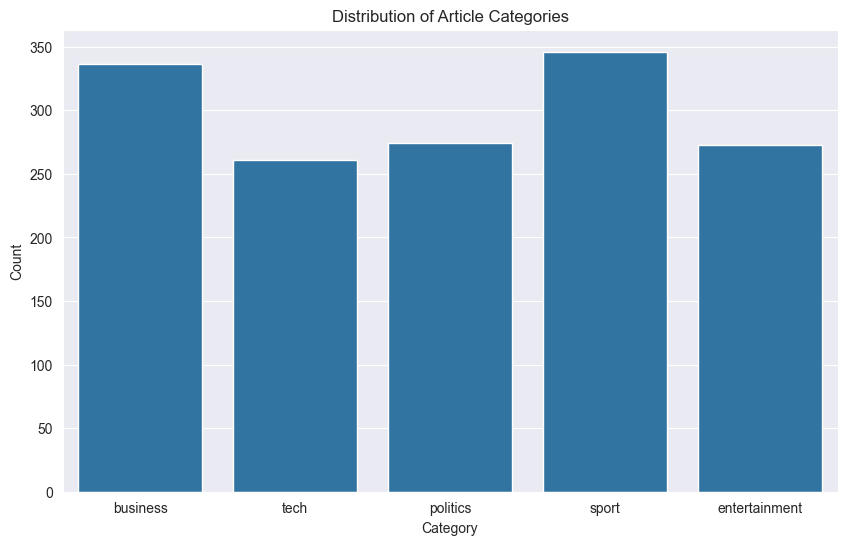

In [67]:
print(train_data['Category'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Category')
plt.title('Distribution of Article Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Through the histogram above, we see that there is a similar distribution of different categories.

In [68]:
# Calculate word count and character count
train_data['word_count'] = train_data['Text'].apply(lambda x: len(x.split()))
train_data['char_count'] = train_data['Text'].apply(lambda x: len(x))

# Display summary statistics for word count and character count
print(train_data[['word_count', 'char_count']].describe())

        word_count    char_count
count  1490.000000   1490.000000
mean    385.012752   2233.461745
std     210.898616   1205.153358
min      90.000000    501.000000
25%     253.000000   1453.000000
50%     337.000000   1961.000000
75%     468.750000   2751.250000
max    3345.000000  18387.000000


Taking a look at the word counts for the Text column we have an average of 385 words across all 1490 articles with a median of 337, while with character count we have an average of 2233 characters with a median of 1961. Next we'll group by categories and see if the distribution of counts by each Article type.

               count        mean         std    min     25%    50%     75%  \
Category                                                                     
business       336.0  334.169643  133.527272  145.0  253.00  304.0  391.25   
entertainment  273.0  333.912088  203.887349  144.0  229.00  272.0  380.00   
politics       274.0  449.689781  258.836242   90.0  319.25  441.5  527.00   
sport          346.0  335.346821  185.443084  116.0  210.25  294.5  412.75   
tech           261.0  501.858238  211.672986  188.0  340.00  457.0  633.00   

                  max  
Category               
business        902.0  
entertainment  2448.0  
politics       3345.0  
sport          1671.0  
tech           1549.0  


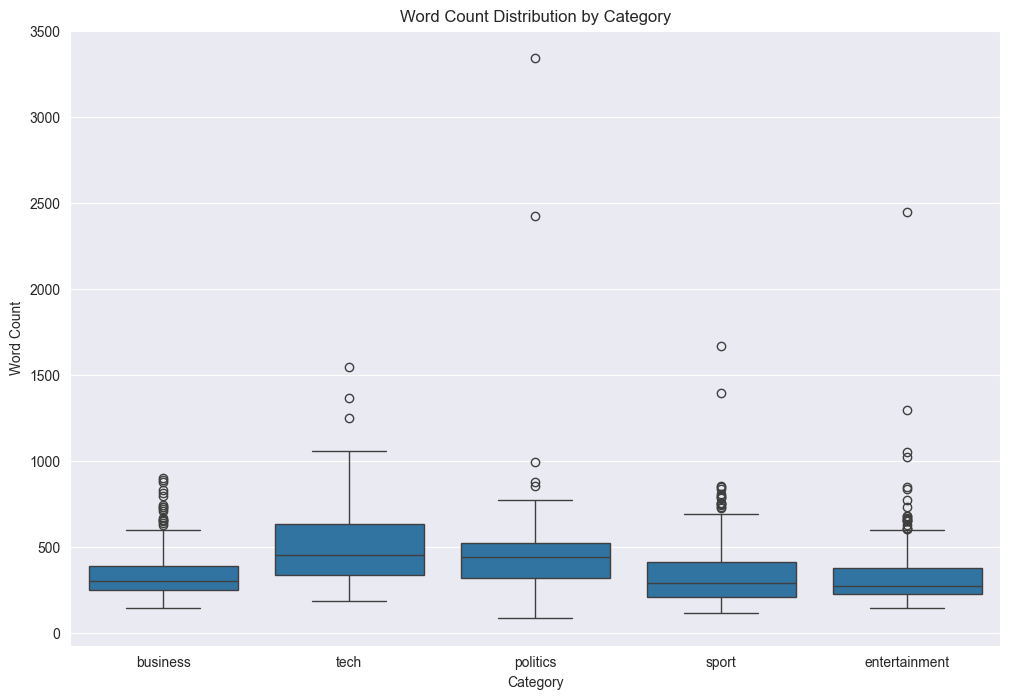

In [69]:
# Group by Category and calculate summary statistics for word count
category_word_count_summary = train_data.groupby('Category')['word_count'].describe()
# Boxplot for word count distribution by category

print(category_word_count_summary)

plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data, x='Category', y='word_count')
plt.title('Word Count Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

From the histogram above we can see the distributions are all fairly similar, with the outliers for each category taking up most of the space on the chart, indicating there are quite a bit of large outliers in this data set. Entertainment and business seem like what have the most, with Politics having the farthest couple outliers in the set. Lets see if that affects the accuracy for those categories based off the test data distributions. 

Next, we'll do some text processing, including things like normalizing the text, removing punctuation,and tokenizing each word.

In [70]:
# Define a function for text cleaning with regex tokenization
def clean_text(text):
    text = text.lower()  # Lowercase conversion
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = re.findall(r'\b\w+\b', text)  # Tokenize text using regex
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply text cleaning
train_data['Cleaned_Text'] = train_data['Text'].apply(clean_text)


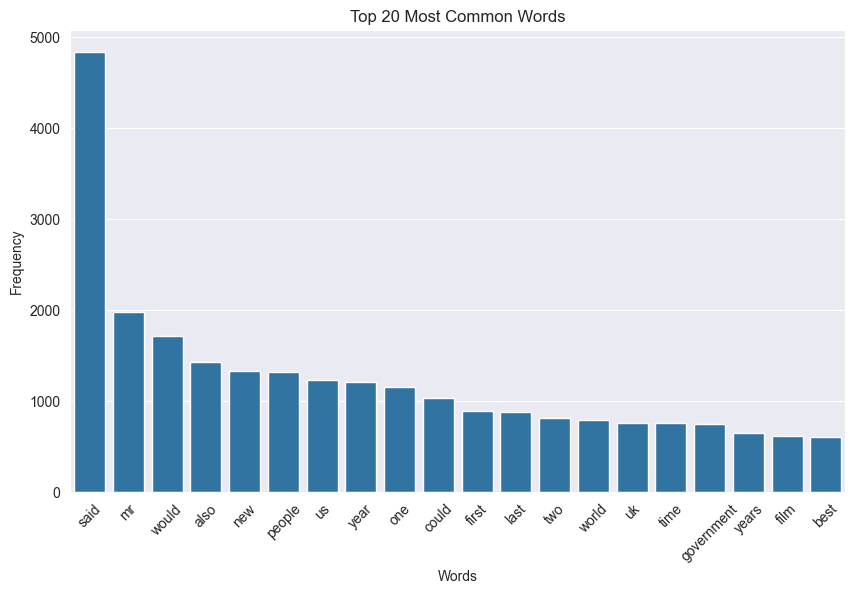

In [71]:
# Get all words from the cleaned text
all_words = ' '.join(train_data['Cleaned_Text']).split()

# Get the word frequency distribution
word_freq = Counter(all_words)

# Plot the word frequency distribution
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Here we have a bar chart of the top 20 most frequently used words across all articles. These words make sense as they're mainly action words and quoting words as well general popular topic words that might surface across the board. I do find it fitting that a series of articles highest word is "said".

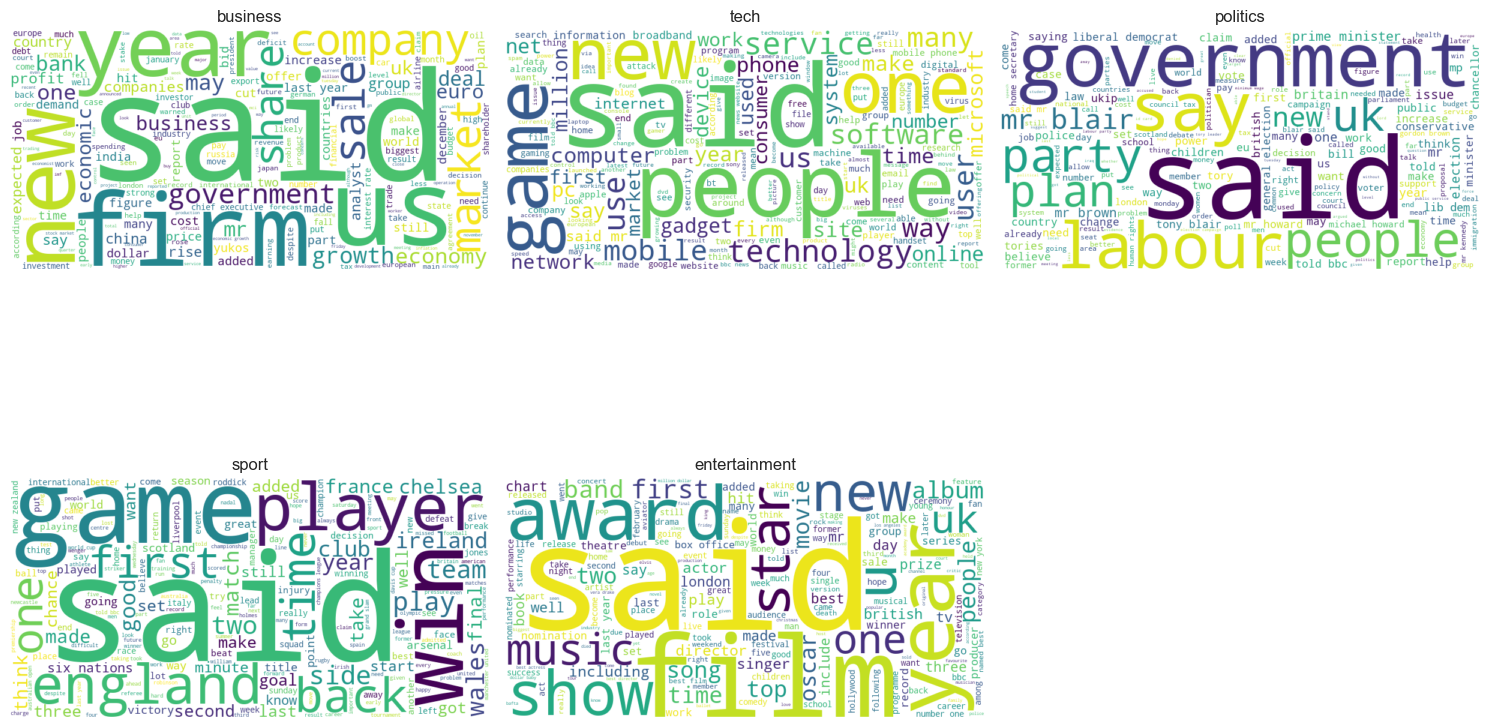

In [72]:
categories = train_data['Category'].unique()

plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    plt.subplot(2, 3, i+1)
    category_text = ' '.join(train_data[train_data['Category'] == category]['Cleaned_Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

As indicated by the bar charts in the previous chart, we see a large prominent "said"in each word cloud, showing how evenly and largely distributed this highest word is in each category. We also see some more fitting words associated in these categoris such as; "win" and "game" in sport, "film" and "award" in entertainment, "firm" and "company" in business, "government" and "labor" in politics, and "people" and "new" in tech.

Based on the EDA step above, my plan for analysis would be to use TF-IDF (Term Frequency-Inverse Document Frequency) to calculate the importance of a word in a document relative to the rest of them. We'll see if applying these varying scores based of TF-IDF can give us a good indication of category. We'll give that a shot and look at some of the numbers. 

In [73]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()  

# Fit and transform the cleaned text data
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Cleaned_Text'])

# Convert to DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF matrix
tfidf_df


,00,000,0001,00051,000acre,000ayear,000bn,000m,000seater,000strong,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.022939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.031692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1488,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, we get a matrix with all the importance scores for each article across every word we see in the entire dataset. This a pretty big matrix so lets do a deeper dive and find out what the highest scores are. 

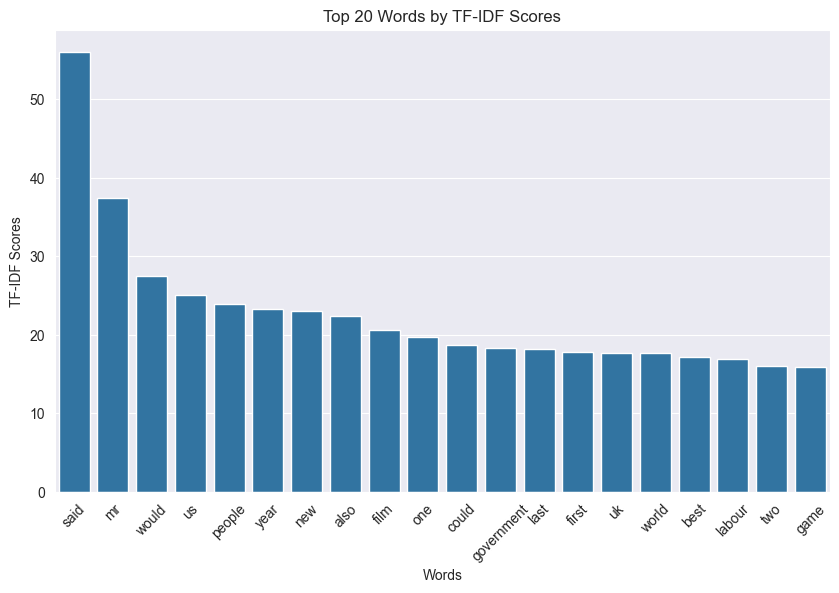

In [74]:
# Get the sum of TF-IDF scores for each word
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)

# Plot the top 20 words by TF-IDF scores
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_sum.head(20).index, y=tfidf_sum.head(20).values)
plt.title('Top 20 Words by TF-IDF Scores')
plt.xlabel('Words')
plt.ylabel('TF-IDF Scores')
plt.xticks(rotation=45)
plt.show()

Now we have a bar chart that shows the highest TF-IDF scores that looks very similar to the top 20 based on raw counts. Lets look at those both again side by side.

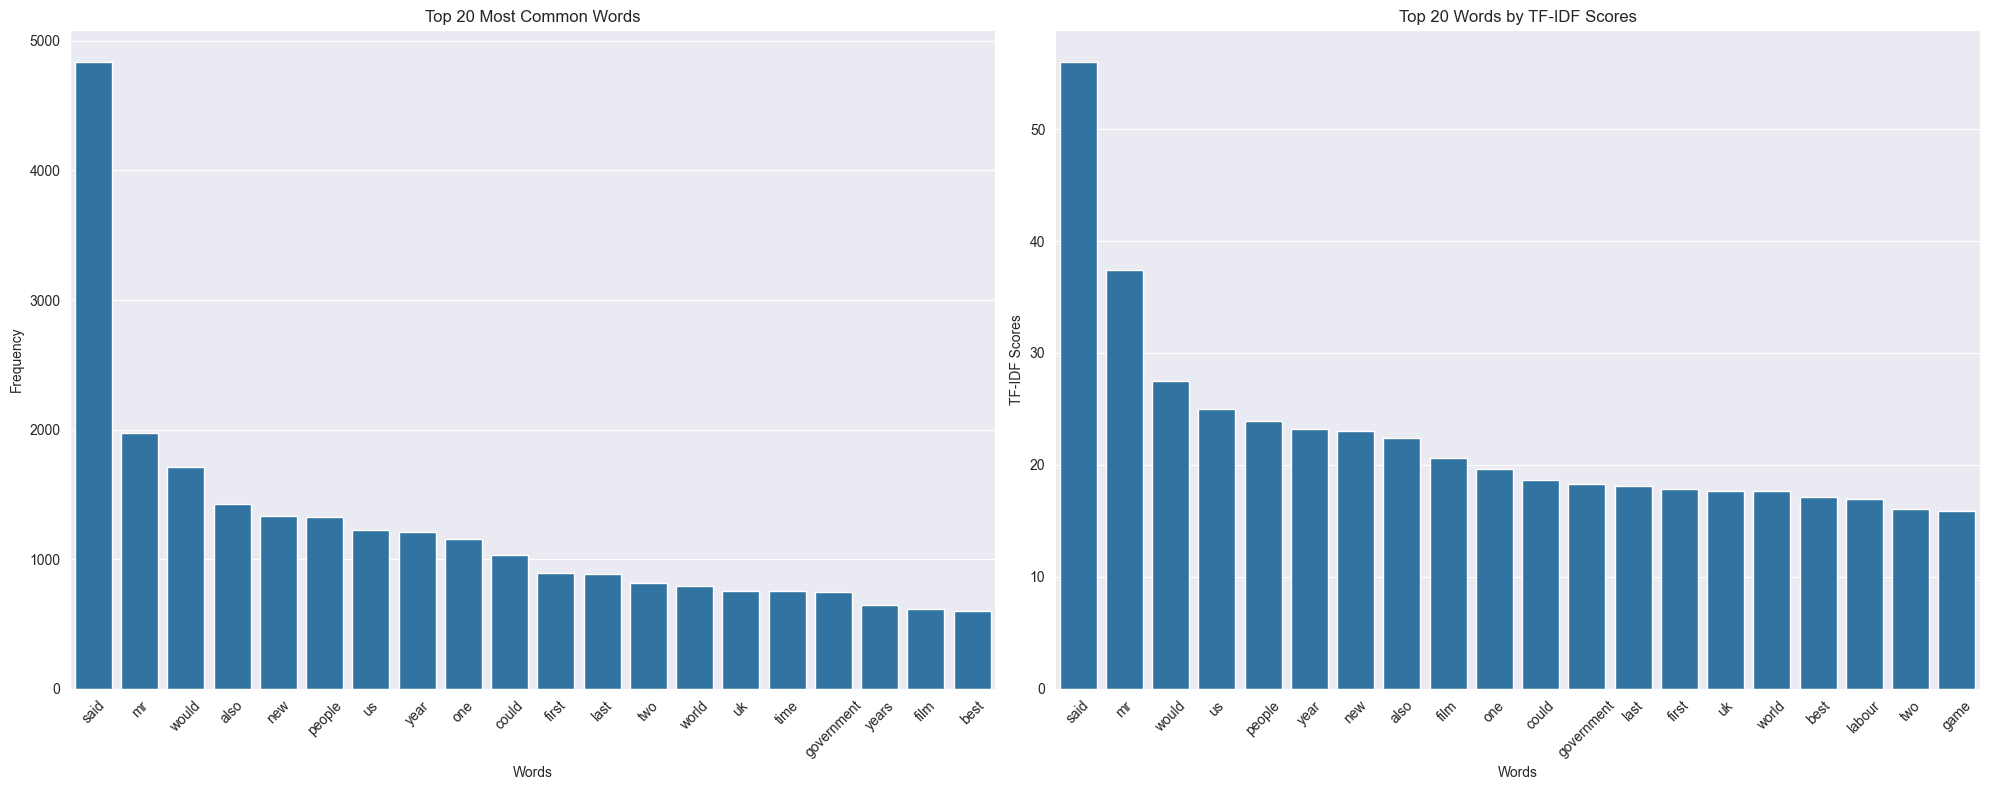

In [75]:
# Most common words by count
most_common_words = word_freq.most_common(20)
words_count, counts = zip(*most_common_words)

# Top words by TF-IDF scores
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)
words_tfidf = tfidf_sum.head(20).index
scores_tfidf = tfidf_sum.head(20).values

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot word frequency count
sns.barplot(x=list(words_count), y=list(counts), ax=axs[0])
axs[0].set_title('Top 20 Most Common Words')
axs[0].set_xlabel('Words')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks(range(len(words_count)))
axs[0].set_xticklabels(words_count, rotation=45)

# Plot TF-IDF scores
sns.barplot(x=words_tfidf, y=scores_tfidf, ax=axs[1])
axs[1].set_title('Top 20 Words by TF-IDF Scores')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('TF-IDF Scores')
axs[1].set_xticks(range(len(words_tfidf)))
axs[1].set_xticklabels(words_tfidf, rotation=45)

plt.tight_layout()
plt.show()

Here we can better see some of the similarities between these two methods of importance. "said", "mr" and "would" all still very important, however the degree of distance is lessened in TF-IDF method, while most of the other words are shuffled around a bit in the rankings with the key difference being "time" and "years" losing their spots on the list to "labour" and "game" as those are most likely high due to their importance specifically in the sports, tech, and politics categories of the data set. 

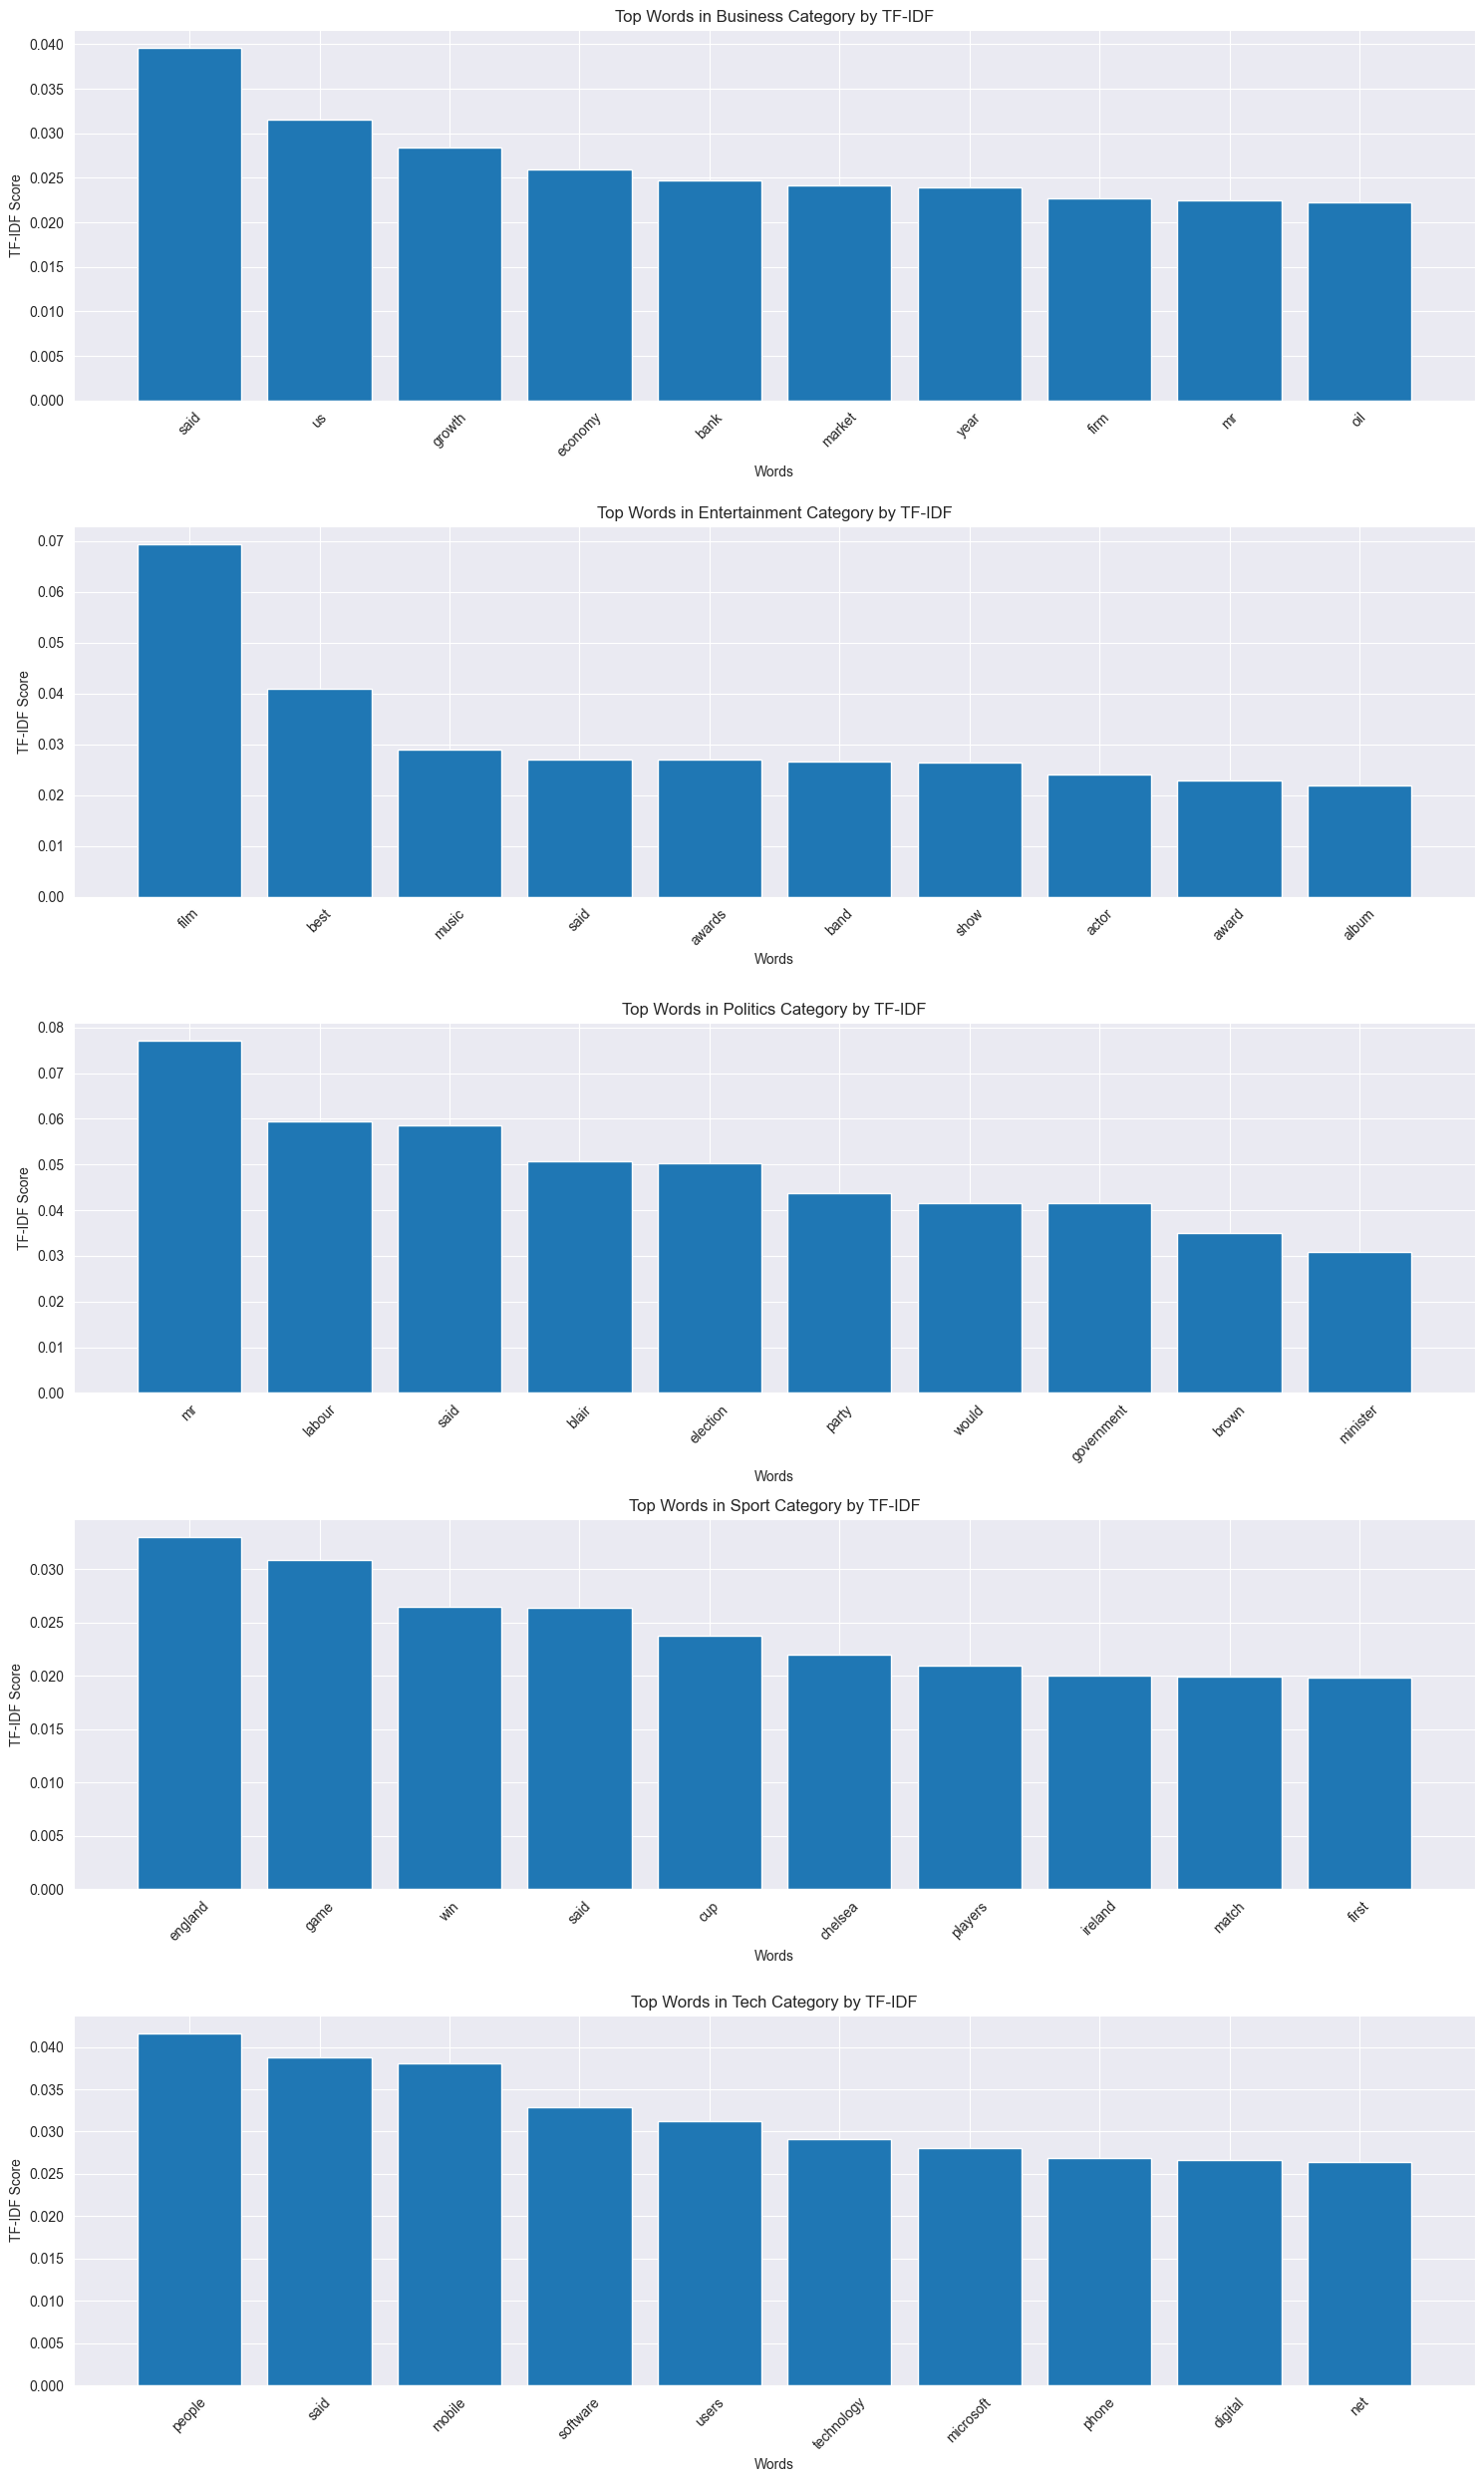

In [76]:
tfidf_df['Category'] = train_data['Category']

# Group by category and calculate the mean TF-IDF score for each word
category_tfidf = tfidf_df.groupby('Category').mean().T

# Get the top 10 words for each category based on TF-IDF scores
top_words_by_category = {}

for category in category_tfidf.columns:
    top_words_by_category[category] = category_tfidf[category].sort_values(ascending=False).head(10)

# Plot the top words for each category
fig, axs = plt.subplots(len(top_words_by_category), 1, figsize=(15, 25))

for i, (category, top_words) in enumerate(top_words_by_category.items()):
    axs[i].bar(top_words.index, top_words.values)
    axs[i].set_title(f'Top Words in {category.capitalize()} Category by TF-IDF')
    axs[i].set_xlabel('Words')
    axs[i].set_ylabel('TF-IDF Score')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Now we can see a more in-depth view of what words are most important in each category of artile. With a wide variety of different important words in each category I believe we have a good feature to employ a categorization model based on matrix factorization to predict the category of the articles in the test data. 

# Building and Training Models

Now we're going to build out our TF-IDF Model and test it out on our training data. We'll create a TF-IDF model based on the training data, specifically excluding the testing data set since we want to test out the best version of our model on data it hasn't seen before and avoid our model overfitting to our test data. We'' use max topics 5 (to match to the 5 categories we have), and see what our accuracy score is for the data set it's trained on. For this first iteration we'll stick with the top 500 features from our TF-IDF matrix 

In [77]:
vectorizer = TfidfVectorizer(max_features=500)

# Number of topics
num_topics = 5

# Results list
results = []

# Fit and transform the cleaned text data
feature_matrix = vectorizer.fit_transform(train_data['Cleaned_Text'])

# Apply NMF
nmf_model = NMF(n_components=num_topics, random_state=42)
W_train = nmf_model.fit_transform(feature_matrix)

# Predict the category for each document in the training set
train_data['Predicted_Topic'] = np.argmax(W_train, axis=1)
topic_to_label = {}
for topic in range(num_topics):
    # Find the most common actual label for the current topic
    most_common_label = train_data[train_data['Predicted_Topic'] == topic]['Category'].mode()[0]
    topic_to_label[topic] = most_common_label

# Map the numerical predictions to categorical labels
train_data['Predicted_Label'] = train_data['Predicted_Topic'].map(topic_to_label)

# Calculate accuracy
train_accuracy = accuracy_score(train_data['Category'], train_data['Predicted_Label'])

print(train_accuracy)

0.8536912751677852


What we see above is the accuracy score for our initial run of our TF-IDF model, 0.8536912751677852 is an ok accuracy score but we can test out different max features to try and get a higher accuracy. For comparison's sake, we'll also use a matrix of count vectorization to compare the nuances of TF-IDF and show how its a better fit for this kind of prediction. 

          Vectorizer  Max_Features  Train_Accuracy
0  TF-IDF Vectorizer           500        0.853691
1  TF-IDF Vectorizer          1000        0.887919
2  TF-IDF Vectorizer          5000        0.918121
3   Count Vectorizer           500        0.679195
4   Count Vectorizer          1000        0.655705
5   Count Vectorizer          5000        0.615436


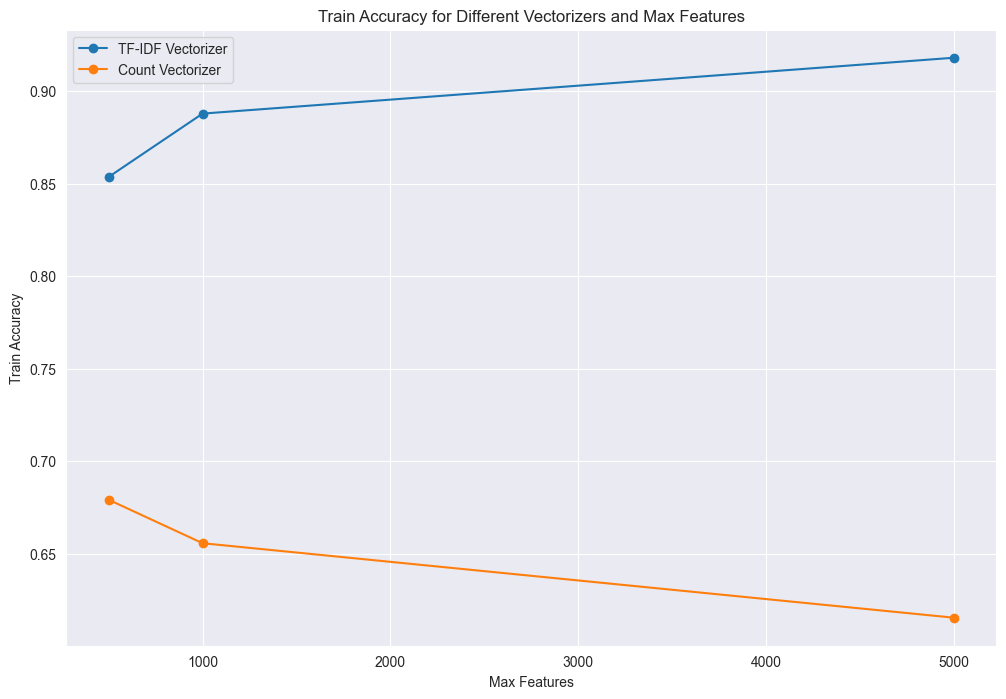

In [78]:
# Define the feature extraction methods and max_features values
max_features_values = [500,1000, 5000]  # None means using all features
vectorizer_classes = {
    'TF-IDF Vectorizer': TfidfVectorizer,
    'Count Vectorizer': CountVectorizer
}

# Number of topics
num_topics = 5

# Results list
results = []

# Iterate through the feature extraction methods and max_features values
for name, vectorizer_class in vectorizer_classes.items():
    for max_features in max_features_values:
        vectorizer = vectorizer_class(max_features=max_features)

        # Fit and transform the cleaned text data
        feature_matrix = vectorizer.fit_transform(train_data['Cleaned_Text'])

        # Apply NMF
        nmf_model = NMF(n_components=num_topics, random_state=42)
        W_train = nmf_model.fit_transform(feature_matrix)

        # Predict the category for each document in the training set
        train_data['Predicted_Topic'] = np.argmax(W_train, axis=1)
        topic_to_label = {}
        for topic in range(num_topics):
            # Find the most common actual label for the current topic
            most_common_label = train_data[train_data['Predicted_Topic'] == topic]['Category'].mode()[0]
            topic_to_label[topic] = most_common_label

        # Map the numerical predictions to categorical labels
        train_data['Predicted_Label'] = train_data['Predicted_Topic'].map(topic_to_label)

        # Calculate accuracy
        train_accuracy = accuracy_score(train_data['Category'], train_data['Predicted_Label'])
        
        # Append results
        results.append((name, max_features, train_accuracy))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Vectorizer', 'Max_Features', 'Train_Accuracy'])
print(results_df)

# Plot the results
plt.figure(figsize=(12, 8))
for name in results_df['Vectorizer'].unique():
    subset = results_df[results_df['Vectorizer'] == name]
    plt.plot(subset['Max_Features'], subset['Train_Accuracy'], label=name, marker='o')

plt.xlabel('Max Features')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy for Different Vectorizers and Max Features')
plt.legend()
plt.show()


After running the model across TF-IDF and count vectorization for 500,1000,and 5000 max features we see an incline in accuracy as we increase max features for TF-IDF, while we see a decrease in accuracy as we scale up max features for the count vectorization. We see here that it is just a better hyperparameter for this modeling. Now lets see what our models with different vectorization and max features can do on our unseen test data. 

In [79]:
max_features_values = [500, 1000, 5000]  # None means using all features
vectorizer_classes = {
    'TF-IDF Vectorizer': TfidfVectorizer,
    'Count Vectorizer': CountVectorizer
}

# Number of topics
num_topics = 5

# Apply text cleaning to the test data
test_data['Cleaned_Text'] = test_data['Text'].apply(clean_text)

# Iterate through the feature extraction methods and max_features values
for name, vectorizer_class in vectorizer_classes.items():
    for max_features in max_features_values:
        vectorizer = vectorizer_class(max_features=max_features)

        # Fit and transform the cleaned text data for the training set
        train_feature_matrix = vectorizer.fit_transform(train_data['Cleaned_Text'])
        
        # Transform the cleaned text data for the test set
        test_feature_matrix = vectorizer.transform(test_data['Cleaned_Text'])

        # Apply NMF
        nmf_model = NMF(n_components=num_topics, random_state=42)
        nmf_model.fit(train_feature_matrix)  # Fit on the training data
        
        # Transform the test data
        W_test = nmf_model.transform(test_feature_matrix)

        # Predict the topic for each document in the test set
        test_data['Predicted_Topic'] = np.argmax(W_test, axis=1)

        # Create the topic to label mapping using the training data
        W_train = nmf_model.transform(train_feature_matrix)
        train_data['Predicted_Topic'] = np.argmax(W_train, axis=1)
        topic_to_label = {}
        for topic in range(num_topics):
            # Find the most common actual label for the current topic
            most_common_label = train_data[train_data['Predicted_Topic'] == topic]['Category'].mode()[0]
            topic_to_label[topic] = most_common_label

        # Map the numerical predictions to categorical labels for the test data
        test_data['Predicted_Label'] = test_data['Predicted_Topic'].map(topic_to_label)

        # Save the results to CSV
        output_filename = f"results_{name.replace(' ', '_')}_max_features_{max_features if max_features else 'All'}.csv"
        output_data = test_data[['ArticleId', 'Predicted_Label']]
        output_data.columns = ['ArticleId', 'Category']
        output_data.to_csv(output_filename, index=False)

The code chunk above saves our different vectorization methods and max features into a solution csv file which then gets entered into the Kaggle for an accuracy score. Below is the scores for each vectorization/max feature combination

![alt text](Kaggle Results.PNG "Kaggle Results")



The results above confirm our tests on the training data that the TF-IDF vectorizer with max features gives us our best score on the test data set of 0.92244.

# Supervised Learning with Logistic Regression

Now we're going to compare the results we got above with a supervised learning model, specifically Logistic Regression. We'll compare the results across our NMF model with the different vectorization and max features to see which methodology works best!

In [80]:
# Results list
supervised_results = []

# Iterate through the feature extraction methods and max_features values
for name, vectorizer_class in vectorizer_classes.items():
    for max_features in max_features_values:
        vectorizer = vectorizer_class(max_features=max_features)

        # Fit and transform the cleaned text data for the training set
        X_train = vectorizer.fit_transform(train_data['Cleaned_Text'])
        y_train = train_data['Category']
        
        # Transform the cleaned text data for the test set
        X_test = vectorizer.transform(test_data['Cleaned_Text'])

        # Train a logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Predict the category for the test set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        test_data['Predicted_Label'] = y_pred_test
        
        # Save the results to CSV
        output_filename = f"supervised_results_{name.replace(' ', '_')}_max_features_{max_features if max_features else 'All'}.csv"
        output_data = test_data[['ArticleId', 'Predicted_Label']]
        output_data.columns = ['ArticleId', 'Category']
        output_data.to_csv(output_filename, index=False)

        # Evaluate performance
        train_accuracy = accuracy_score(y_train, y_pred_train)
        
        # Save results
        supervised_results.append((name, max_features if max_features else 'All Features', train_accuracy))

# Convert results to DataFrame
supervised_results_df = pd.DataFrame(supervised_results, columns=['Vectorizer', 'Max_Features', 'Train_Accuracy'])
print(supervised_results_df)

          Vectorizer  Max_Features  Train_Accuracy
0  TF-IDF Vectorizer           500        0.983221
1  TF-IDF Vectorizer          1000        0.988591
2  TF-IDF Vectorizer          5000        0.996644
3   Count Vectorizer           500        1.000000
4   Count Vectorizer          1000        1.000000
5   Count Vectorizer          5000        1.000000


In [81]:
# Assuming unsupervised_results_df has the unsupervised learning results with similar columns
unsupervised_results_df = results_df  # Use the results from the previous unsupervised learning part

# Merge both results for comparison
comparison_df = supervised_results_df.merge(unsupervised_results_df, on=['Vectorizer', 'Max_Features'], suffixes=('_Supervised', '_Unsupervised'))
display(comparison_df)

,Vectorizer,Max_Features,Train_Accuracy_Supervised,Train_Accuracy_Unsupervised
0,TF-IDF Vectorizer,500,0.983221,0.853691
1,TF-IDF Vectorizer,1000,0.988591,0.887919
2,TF-IDF Vectorizer,5000,0.996644,0.918121
3,Count Vectorizer,500,1.000000,0.679195
4,Count Vectorizer,1000,1.000000,0.655705
5,Count Vectorizer,5000,1.000000,0.615436


Interestingly enough, our count vectorization has some issues with the modeling in this case which most likely largely overfits to the training data. but our supervised versions of this model outperform our unsupervised models in every iteration of our model. From the table above, we see very high accuracy scores compared across. When looking at the test data from kaggle, we get similar results that are much better than our original submissions

![alt text](Supervised Kaggle Results.PNG "Kaggle Results")

From this we can see that LogisticRegression is the better method of modeling for this specific case, and version of an TF-IDF, NMF model. Now we'll take a look at the data efficiency of these models and see what our issue might be with overfitting. For these purposes, we won't iterate over our count vectorization. 

In [82]:
# Function to train and evaluate a supervised model with different sizes of training data
def evaluate_supervised_model(train_data, test_data, vectorizer_class, max_features, sizes):
    results = []
    for size in sizes:
        # Sample the training data
        train_sample = train_data.sample(frac=size, random_state=42)
        vectorizer = vectorizer_class(max_features=max_features)

        # Fit and transform the cleaned text data for the training set
        X_train = vectorizer.fit_transform(train_sample['Cleaned_Text'])
        y_train = train_sample['Category']
        
        # Transform the cleaned text data for the test set
        X_test = vectorizer.transform(test_data['Cleaned_Text'])

        # Train a logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Predict the category for the test set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        test_data['Predicted_Label'] = y_pred_test
        
        # Save the results to CSV
        output_filename = f"supervised_results_{size}_{name.replace(' ', '_')}_max_features_{max_features if max_features else 'All'}.csv"
        output_data = test_data[['ArticleId', 'Predicted_Label']]
        output_data.columns = ['ArticleId', 'Category']
        output_data.to_csv(output_filename, index=False)

        # Evaluate performance
        train_accuracy = accuracy_score(y_train, y_pred_train)
        
        # Save results
        results.append((size, train_accuracy))
    
    return pd.DataFrame(results, columns=['Train_Size', 'Train_Accuracy'])

# Evaluate the supervised model for different sizes of training data
sizes = [0.1, 0.2, 0.5]
vectorizer_classes = {
    'TF-IDF Vectorizer': TfidfVectorizer
}
for name, vectorizer_class in vectorizer_classes.items():
    for max_features in max_features_values:
        results_df = evaluate_supervised_model(train_data, test_data, vectorizer_class, max_features, sizes)
        print(f"Results for {name} with max_features={max_features if max_features else 'All Features'}")
        print(results_df)


Results for TF-IDF Vectorizer with max_features=500
   Train_Size  Train_Accuracy
0         0.1        1.000000
1         0.2        0.989933
2         0.5        0.987919
Results for TF-IDF Vectorizer with max_features=1000
   Train_Size  Train_Accuracy
0         0.1        1.000000
1         0.2        0.996644
2         0.5        0.997315
Results for TF-IDF Vectorizer with max_features=5000
   Train_Size  Train_Accuracy
0         0.1        1.000000
1         0.2        1.000000
2         0.5        0.998658


From the results above we can see that we have a really good prediction model on the training data at just 0.1 the size of the training data set, essentially across all 4 max features for TF-IDF NMF modeling. For data efficiency purposes on the training model, we only need 500 features with just 0.1 the size of the training data. Lets take a look at what the test data results give us. 

![alt text](size_supervised_results.PNG "Kaggle Results")

We can see based off the high accuracy scores for the training data at 0.1 the training size and the accuracy scores for the test data in that same iteration that we have some overfitting issues in the training set. We see rather high marks within these results but we see our highest at 0.5 the training size and 5000 max features. This does not match the 1.0 accuracy of the training set and therfore can understand some overfitting to be happening here. 

In conclusion, we find that in this case with the models we've built, the NMF unsupervised method of modeling does not out perform Logistic regression for this set of train/test data, under the hyperparameters I set. 